In [15]:
import os
import time
from dataclasses import dataclass
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)

from datasets import load_dataset
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [16]:
dataset = load_dataset("dair-ai/emotion", "split")  # 16k/2k/2k split
print(dataset)

label_names = dataset["train"].features["label"].names
num_labels = len(label_names)
id2label = {i: name for i, name in enumerate(label_names)}
label2id = {name: i for i, name in enumerate(label_names)}

label_names, id2label


MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 128  
def tokenize_batch(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )


encoded = dataset.map(tokenize_batch, batched=True)
encoded.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"],
)


class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, ds):
        self.ds = ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        return {
            "input_ids": item["input_ids"],
            "attention_mask": item["attention_mask"],
            "labels": item["label"],
        }


train_ds = EmotionDataset(encoded["train"])
val_ds   = EmotionDataset(encoded["validation"])
test_ds  = EmotionDataset(encoded["test"])

#DATALOADER
BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)



DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


# 1) BASELINE FINETUNING

In [17]:
# Model for classification 

class BertEmotionClassifier(nn.Module):
    def __init__(self, base_model_name: str, num_labels: int):
        super().__init__()
        self.bert = AutoModel.from_pretrained(base_model_name)
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        pooled = outputs.last_hidden_state[:, 0]  # CLS token
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)

        return {"loss": loss, "logits": logits}


In [18]:
#Training 

EPOCHS = 10
LR = 2e-5
MODEL_NAME = "bert-base-uncased"
FREEZE_LAYERS_BELOW = 6  
baseline_model = BertEmotionClassifier(MODEL_NAME, num_labels=num_labels)
baseline_model.to(device)
for name, param in baseline_model.bert.named_parameters():
    if name.startswith("embeddings") or "encoder.layer.0" in name or "encoder.layer.1" in name or \
       "encoder.layer.2" in name or "encoder.layer.3" in name or "encoder.layer.4" in name or \
       "encoder.layer.5" in name:
        param.requires_grad = False

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, baseline_model.parameters()),
    lr=LR,
)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps,
)
scaler = torch.amp.GradScaler(
    "cuda"
)



In [19]:

for epoch in range(EPOCHS):
    baseline_model.train()
    running_loss = 0.0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            out = baseline_model(input_ids, attention_mask, labels=labels)
            loss = out["loss"]

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train loss: {avg_loss:.4f}")
os.makedirs("models/baseline", exist_ok=True)
torch.save(baseline_model.state_dict(), "models/baseline/bert_emotion_baseline_rohit_anlp.pt")


/tmp/ipykernel_290751/475781479.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10 | Train loss: 1.2129
Epoch 2/10 | Train loss: 0.3953
Epoch 3/10 | Train loss: 0.2291
Epoch 4/10 | Train loss: 0.1724
Epoch 5/10 | Train loss: 0.1344
Epoch 6/10 | Train loss: 0.1193
Epoch 7/10 | Train loss: 0.1059
Epoch 8/10 | Train loss: 0.0911
Epoch 9/10 | Train loss: 0.0838
Epoch 10/10 | Train loss: 0.0754


# 2) POST TRAININGG QUANTIZATION (PTQ)

In [20]:
base_dir = os.getcwd()
pretrained_model_name = "bert_emotion_baseline_rohit_anlp.pt"
baseline_weights_path = os.path.join(base_dir, "models", "baseline", pretrained_model_name)

path_to_load = None
if os.path.exists(baseline_weights_path):
    path_to_load = baseline_weights_path
else:
    print("Model weights not found in the notebook directory. Path change is required")
    print(" -", baseline_weights_path)

if path_to_load:
    baseline_model = BertEmotionClassifier(MODEL_NAME, num_labels=num_labels)
    baseline_model.load_state_dict(torch.load(path_to_load, map_location=device))
    baseline_model.to(device)
    baseline_model.eval()


In [39]:
@torch.no_grad()
def evaluate_model(model: nn.Module, data_loader: DataLoader,device="cuda") -> Dict[str, float]:
    model.eval()
    all_labels = []
    all_preds = []
    all_logits = []

    start = time.perf_counter()

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].cpu().numpy()
        out = model(input_ids, attention_mask)
        logits = out["logits"].cpu().numpy()
        preds = np.argmax(logits, axis=-1)
        all_labels.extend(labels.tolist())
        all_preds.extend(preds.tolist())
        all_logits.append(logits)

    end = time.perf_counter()
    latency_per_example_ms = (end - start) * 1000.0 / len(all_labels)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return {
        "macro_f1": macro_f1,
        "accuracy": acc,
        "latency_ms_per_example": latency_per_example_ms,
        "confusion_matrix": cm,
        "y_true": np.array(all_labels),
        "y_pred": np.array(all_preds),
    }


In [22]:
# Model Size Utitlity

def model_size_mb(model: nn.Module) -> float:
    tmp_path = "temp_model.pt"
    torch.save(model.state_dict(), tmp_path)
    size_mb = os.path.getsize(tmp_path) / (1024 * 1024)
    os.remove(tmp_path)
    return size_mb


In [37]:
import torch.ao.quantization as quant
ptq_model = BertEmotionClassifier(MODEL_NAME, num_labels=num_labels)
ptq_model.load_state_dict(torch.load(baseline_weights_path, map_location="cpu"))
ptq_model.eval()
#Ihave performed post quantization on the baseline model on linear layers
ptq_model_int8 = quant.quantize_dynamic(
    ptq_model,
    {nn.Linear},
    dtype=torch.qint8,
)

ptq_model_int8.to("cpu")
ptq_model_int8.eval()
os.makedirs(os.path.join("models", "ptq"), exist_ok=True)
torch.save(ptq_model_int8.state_dict(), os.path.join("models", "ptq", "bert_emotion_ptq.pt"))


/tmp/ipykernel_290751/1504794502.py:6: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  ptq_model_int8 = quant.quantize_dynamic(


baseline macro F1: 0.8678025393897654
baseline accuracy: 0.916
baseline latency (ms/example): 2.251600073497684
baseline size (MB): 417.738000869751


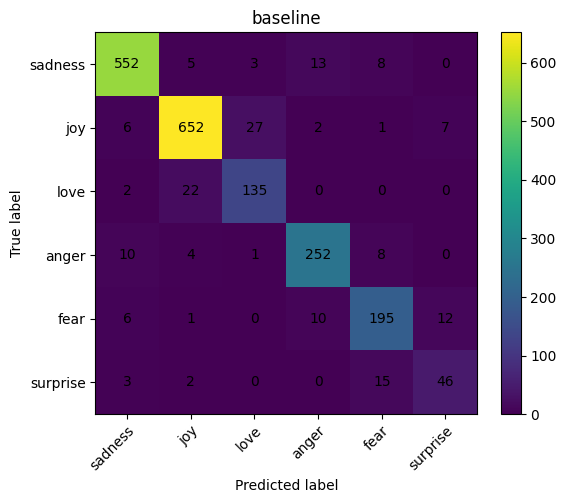

              precision    recall  f1-score   support

     sadness       0.95      0.95      0.95       581
         joy       0.95      0.94      0.94       695
        love       0.81      0.85      0.83       159
       anger       0.91      0.92      0.91       275
        fear       0.86      0.87      0.86       224
    surprise       0.71      0.70      0.70        66

    accuracy                           0.92      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000



In [40]:
#Evaluating the model on metrics f1-macro , accuracy , and latency 
%matplotlib inline 
baseline_metrics = evaluate_model(baseline_model, test_loader,device="cuda")
baseline_size = model_size_mb(baseline_model)

print("baseline macro F1:", baseline_metrics["macro_f1"])
print("baseline accuracy:", baseline_metrics["accuracy"])
print("baseline latency (ms/example):", baseline_metrics["latency_ms_per_example"])
print("baseline size (MB):", baseline_size)
def plot_confusion(cm, class_names, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="True label",
        xlabel="Predicted label",
        title=title,
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
            )
    fig.tight_layout()
    plt.show()

plot_confusion(baseline_metrics["confusion_matrix"], label_names, title="baseline")
print(classification_report(baseline_metrics["y_true"], baseline_metrics["y_pred"], target_names=label_names))


ptq macro F1: 0.8729364742867894
ptq accuracy: 0.913
ptq latency (ms/example): 37.966236720996676
ptq size (MB): 173.09013175964355


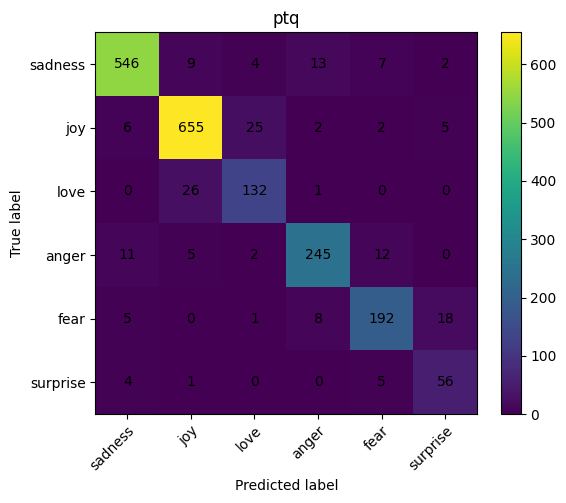

              precision    recall  f1-score   support

     sadness       0.95      0.94      0.95       581
         joy       0.94      0.94      0.94       695
        love       0.80      0.83      0.82       159
       anger       0.91      0.89      0.90       275
        fear       0.88      0.86      0.87       224
    surprise       0.69      0.85      0.76        66

    accuracy                           0.91      2000
   macro avg       0.86      0.88      0.87      2000
weighted avg       0.92      0.91      0.91      2000



In [41]:
#Evaluating the model on metrics f1-macro , accuracy , and latency 
%matplotlib inline 
ptq_metrics = evaluate_model(ptq_model_int8, test_loader,device="cpu")
ptq_size = model_size_mb(ptq_model_int8)

print("ptq macro F1:", ptq_metrics["macro_f1"])
print("ptq accuracy:", ptq_metrics["accuracy"])
print("ptq latency (ms/example):", ptq_metrics["latency_ms_per_example"])
print("ptq size (MB):", ptq_size)
def plot_confusion(cm, class_names, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="True label",
        xlabel="Predicted label",
        title=title,
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
            )
    fig.tight_layout()
    plt.show()

plot_confusion(ptq_metrics["confusion_matrix"], label_names, title="ptq")
print(classification_report(ptq_metrics["y_true"], ptq_metrics["y_pred"], target_names=label_names))


# 3) QUANTIZATION AWARE TRAINING (QAT)

In [42]:
from torch.ao.quantization import QuantStub, DeQuantStub, QConfig, get_default_qat_qconfig

class QATBertEmotionClassifier(BertEmotionClassifier):
    def __init__(self, base_model_name: str, num_labels: int):
        super().__init__(base_model_name, num_labels)
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        pooled = outputs.last_hidden_state[:, 0]
        pooled = self.dropout(pooled)
        q = self.quant(pooled)
        logits = self.classifier(q)
        logits = self.dequant(logits)

        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
        return {"loss": loss, "logits": logits}
qat_model = QATBertEmotionClassifier(MODEL_NAME, num_labels=num_labels)
qat_model.load_state_dict(torch.load(baseline_weights_path, map_location="cpu"))

for param in qat_model.bert.parameters():
    param.requires_grad = False

qat_model.qconfig = get_default_qat_qconfig("fbgemm")
print(qat_model.qconfig)

quant.prepare_qat(qat_model, inplace=True)
qat_model.to(device)


QConfig(activation=functools.partial(<class 'torch.ao.quantization.fake_quantize.FusedMovingAvgObsFakeQuantize'>, observer=<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, quant_min=0, quant_max=255, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.fake_quantize.FusedMovingAvgObsFakeQuantize'>, observer=<class 'torch.ao.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})


/tmp/ipykernel_290751/2018364127.py:33: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quant.prepare_qat(qat_model, inplace=True)
/home/protomate/miniconda3/envs/anlp/lib/python3.11/site-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in 

QATBertEmotionClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(
        30522, 768, padding_idx=0
        (activation_post_process): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
          (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
        )
      )
      (position_embeddings): Embedding(
        512, 768
        (activation_post_process): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=12

In [43]:
EPOCHS = 5
QAT_LR = 1e-4

optimizer_qat = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, qat_model.parameters()),
    lr=QAT_LR,
)

for epoch in range(EPOCHS):
    qat_model.train()
    total_loss = 0.0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer_qat.zero_grad(set_to_none=True)
        out = qat_model(input_ids, attention_mask, labels=labels)
        loss = out["loss"]
        loss.backward()
        optimizer_qat.step()

        total_loss += loss.item()

    print(f"[QAT] Epoch {epoch+1}/{EPOCHS}, loss={total_loss/len(train_loader):.4f}")
qat_model.eval()

os.makedirs(os.path.join("models", "qat"), exist_ok=True)
torch.save(qat_model.state_dict(), os.path.join("models", "qat", "bert_emotion_qat.pt"))

[QAT] Epoch 1/5, loss=0.4381
[QAT] Epoch 2/5, loss=0.3871
[QAT] Epoch 3/5, loss=0.3710
[QAT] Epoch 4/5, loss=0.3658
[QAT] Epoch 5/5, loss=0.3687


qat macro F1: 0.8433933367675815
qat accuracy: 0.8885
qat latency (ms/example): 2.913392920498154
qat size (MB): 419.4839868545532


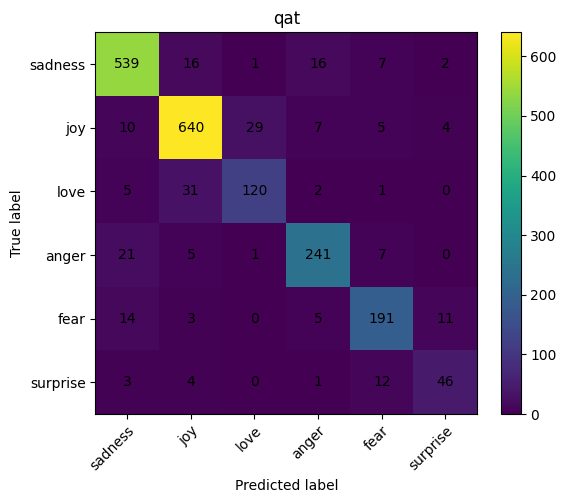

              precision    recall  f1-score   support

     sadness       0.91      0.93      0.92       581
         joy       0.92      0.92      0.92       695
        love       0.79      0.75      0.77       159
       anger       0.89      0.88      0.88       275
        fear       0.86      0.85      0.85       224
    surprise       0.73      0.70      0.71        66

    accuracy                           0.89      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.89      0.89      0.89      2000



In [44]:
qat_metrics = evaluate_model(qat_model, test_loader)
qat_size = model_size_mb(qat_model)

print("qat macro F1:", qat_metrics["macro_f1"])
print("qat accuracy:", qat_metrics["accuracy"])
print("qat latency (ms/example):", qat_metrics["latency_ms_per_example"])
print("qat size (MB):", qat_size)
plot_confusion(qat_metrics["confusion_matrix"], label_names, title="qat")
print(classification_report(qat_metrics["y_true"], qat_metrics["y_pred"], target_names=label_names))

# 4) QLoRA (QUANTIZED LOW RANK ADAPTATION)

In [26]:
from peft import LoraConfig, get_peft_model
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
# I am agian looading the model because I have to specify QLoRA configs
qlora_base = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    quantization_config=bnb_config,
    device_map="cuda",
)
lora_config = LoraConfig(
    r=8,                
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    target_modules=["query", "value", "key", "output.dense"], 
)

qlora_model = get_peft_model(qlora_base, lora_config)
qlora_model.print_trainable_parameters()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 963,078 || all params: 110,449,932 || trainable%: 0.8720


In [27]:
EPOCHS = 5
QLORA_LR = 2e-4
optimizer_qlora = torch.optim.AdamW(
    qlora_model.parameters(),
    lr=QLORA_LR,
)

for epoch in range(EPOCHS):
    qlora_model.train()
    total_loss = 0.0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer_qlora.zero_grad(set_to_none=True)
        outputs = qlora_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )
        loss = outputs.loss
        loss.backward()
        optimizer_qlora.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, loss={total_loss/len(train_loader):.4f}")

os.makedirs(os.path.join("models", "qlora"), exist_ok=True)
qlora_model.save_pretrained(os.path.join("models", "qlora"))


Epoch 1/5, loss=nan
Epoch 2/5, loss=nan
Epoch 3/5, loss=nan
Epoch 4/5, loss=nan
Epoch 5/5, loss=nan


In [28]:
qlora_model_loaded = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    quantization_config=bnb_config,
    device_map="auto",
)
from peft import PeftModel

qlora_model_loaded = PeftModel.from_pretrained(
    qlora_model_loaded,
    os.path.join("models", "qlora"),
)
qlora_model_loaded.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      

QLoRA macro F1: 0.07503551594989022
QLoRA accuracy: 0.2905
QLoRA latency (ms/example): 1.0203118819990777
QLoRA size (MB): 91.84484958648682


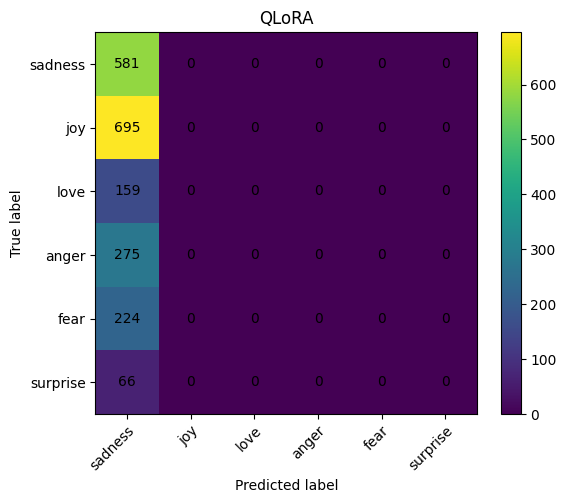

              precision    recall  f1-score   support

     sadness       0.29      1.00      0.45       581
         joy       0.00      0.00      0.00       695
        love       0.00      0.00      0.00       159
       anger       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       224
    surprise       0.00      0.00      0.00        66

    accuracy                           0.29      2000
   macro avg       0.05      0.17      0.08      2000
weighted avg       0.08      0.29      0.13      2000



/home/protomate/miniconda3/envs/anlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/protomate/miniconda3/envs/anlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/protomate/miniconda3/envs/anlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

In [31]:
@torch.no_grad()
def evaluate_hf_seqcls_model(model, data_loader):
    model.eval()
    y_true, y_pred = [], []
    start = time.perf_counter()

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].cpu().numpy()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        logits = outputs.logits.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)

        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())

    end = time.perf_counter()
    latency = (end - start) * 1000.0 / len(y_true)

    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return {
        "macro_f1": macro_f1,
        "accuracy": acc,
        "latency_ms_per_example": latency,
        "confusion_matrix": cm,
        "y_true": np.array(y_true),
        "y_pred": np.array(y_pred),
    }

qlora_metrics = evaluate_hf_seqcls_model(qlora_model_loaded, test_loader)
qlora_size = model_size_mb(qlora_model_loaded) 

print("QLoRA macro F1:", qlora_metrics["macro_f1"])
print("QLoRA accuracy:", qlora_metrics["accuracy"])
print("QLoRA latency (ms/example):", qlora_metrics["latency_ms_per_example"])
print("QLoRA size (MB):", qlora_size)
plot_confusion(qlora_metrics["confusion_matrix"], label_names, title="QLoRA")
print(classification_report(qlora_metrics["y_true"], qlora_metrics["y_pred"], target_names=label_names))


In [45]:
# Finally comparing every model

import pandas as pd

results_table = pd.DataFrame(
    [
        {
            "Model": "Baseline (FP32/FP16)",
            "Macro F1": baseline_metrics["macro_f1"],
            "Accuracy": baseline_metrics["accuracy"],
            "Size (MB)": baseline_size,
            "Latency (ms/example)": baseline_metrics["latency_ms_per_example"],
        },
        {
            "Model": "PTQ (Dynamic INT8)",
            "Macro F1": ptq_metrics["macro_f1"],
            "Accuracy": ptq_metrics["accuracy"],
            "Size (MB)": ptq_size,
            "Latency (ms/example)": ptq_metrics["latency_ms_per_example"],
        },
        {
            "Model": "QAT (Head INT8)",
            "Macro F1": qat_metrics["macro_f1"],
            "Accuracy": qat_metrics["accuracy"],
            "Size (MB)": qat_size,
            "Latency (ms/example)": qat_metrics["latency_ms_per_example"],
        },
        {
            "Model": "QLoRA (4-bit + LoRA)",
            "Macro F1": qlora_metrics["macro_f1"],
            "Accuracy": qlora_metrics["accuracy"],
            "Size (MB)": qlora_size,
            "Latency (ms/example)": qlora_metrics["latency_ms_per_example"],
        },
    ]
)

print(results_table.round(4))


                  Model  Macro F1  Accuracy  Size (MB)  Latency (ms/example)
0  Baseline (FP32/FP16)    0.8678    0.9160   417.7380                2.2516
1    PTQ (Dynamic INT8)    0.8729    0.9130   173.0901               37.9662
2       QAT (Head INT8)    0.8434    0.8885   419.4840                2.9134
3  QLoRA (4-bit + LoRA)    0.0750    0.2905    91.8448                1.0203
